#WEEK 1

In [ ]:
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks
from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models
from tensorflow.keras.applications import EfficientNetV2B2  # Pretrained EfficientNetV2B0 model for transfer learning
from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet
import numpy as np  # Numerical operations and array handling
import matplotlib.pyplot as plt  # Plotting graphs and images
import seaborn as sns  # Plotting graphs and images
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models
import gradio as gr  # Web interface library to deploy and test ML models
from PIL import Image  # For image file loading and basic image operations
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
testpath= '/content/drive/My Drive/test'
trainpath= '/content/drive/My Drive/train'
validpath = '/content/drive/My Drive/val'

In [ ]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (260,260), batch_size = 30, validation_split= False)

Found 2400 files belonging to 10 classes.


In [ ]:
datatest= tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (260,260), batch_size = 30, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = False, image_size = (260,260), batch_size = 30, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


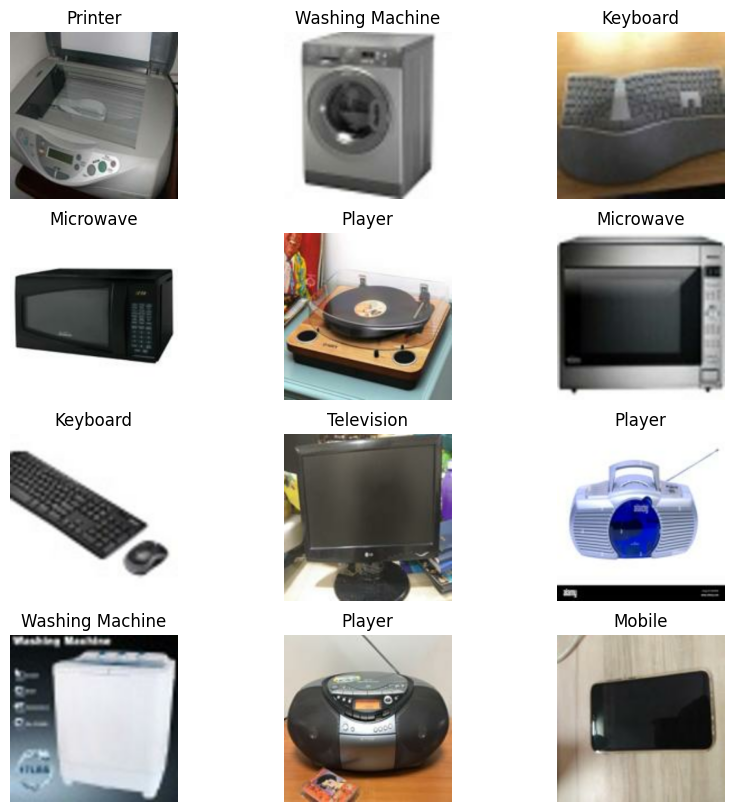

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in datatrain.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):

    class_counts = {}

    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

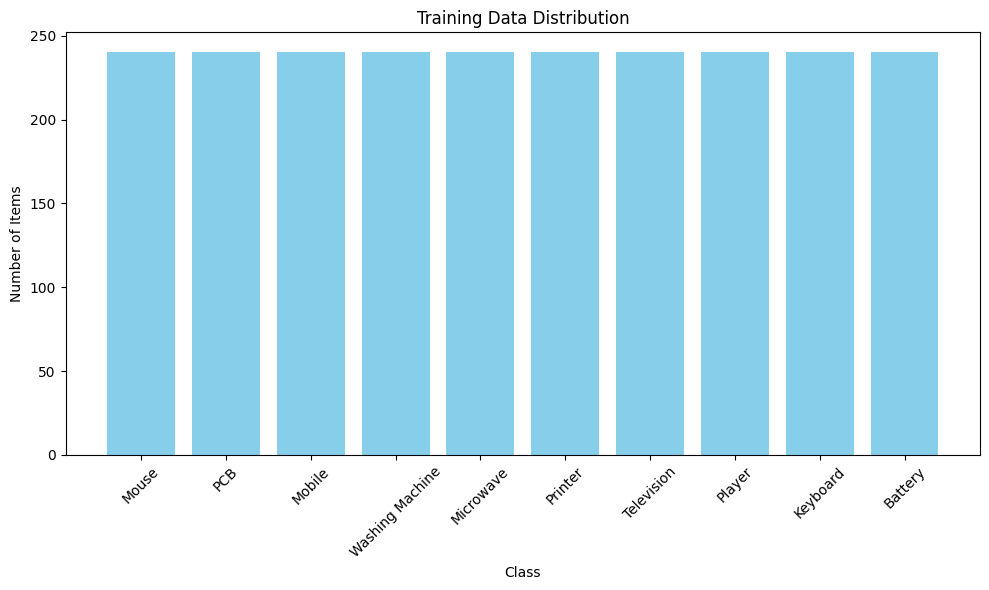

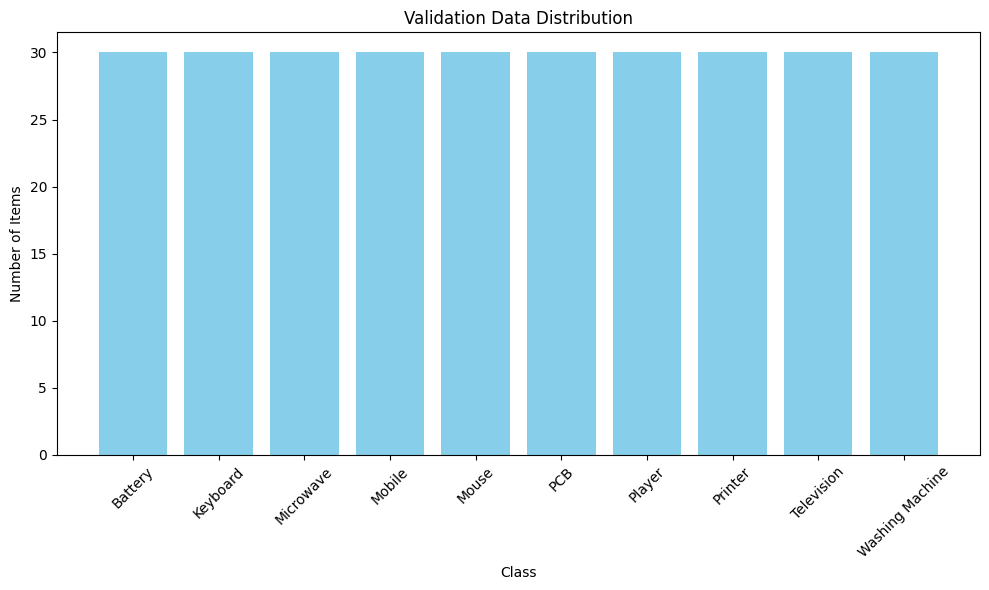

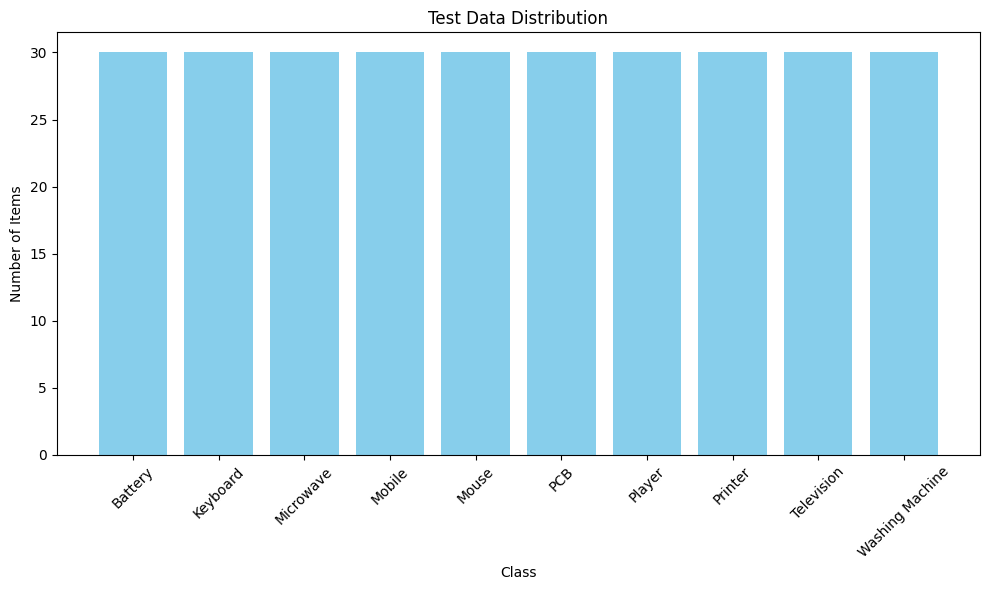

In [ ]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

#WEEK 2

The changes I have implemented in this code is to change the model type from EfficientNetV2B0 to EfficientNetV2B2. With this, there has been a significant increase in the accuracy of the model and it can observed from the graph and the confusion matrix.

## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet)

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.1)
                                         ,tf.keras.layers.RandomZoom(0.1),])

## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B0`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(input_shape=(260,260, 3),include_top=False,weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`,
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(260,260, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

###  Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving.

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=4,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [ ]:
epochs = 10

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 86s 404ms/step - Accuracy: 0.3289 - loss: 2.0737 - val_Accuracy: 0.8600 - val_loss: 1.1988
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - Accuracy: 0.8261 - loss: 1.0512 - val_Accuracy: 0.9433 - val_loss: 0.4743
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - Accuracy: 0.9011 - loss: 0.5096 - val_Accuracy: 0.9600 - val_loss: 0.2475
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 341ms/step - Accuracy: 0.9418 - loss: 0.2756 - val_Accuracy: 0.9600 - val_loss: 0.1681
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 341ms/step - Accuracy: 0.9450 - loss: 0.2114 - val_Accuracy: 0.9667 - val_loss: 0.1245
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - Accuracy: 0.9626 - loss: 0.1632 - val_Accuracy: 0.9667 - val_loss: 0.1122
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 355ms/step - Accuracy: 0.9764 - loss: 0.1165 - val_Accuracy: 0.9700 - val_loss: 0.1096
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 337ms/step - Accuracy: 0.9762 - loss: 0.1007 - val_Accu

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        14,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,744,022 (94.39 MB)

 Trainable params: 7,980,278 (30.44 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,960,558 (60.88 MB)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 260, 260,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [ ]:
acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

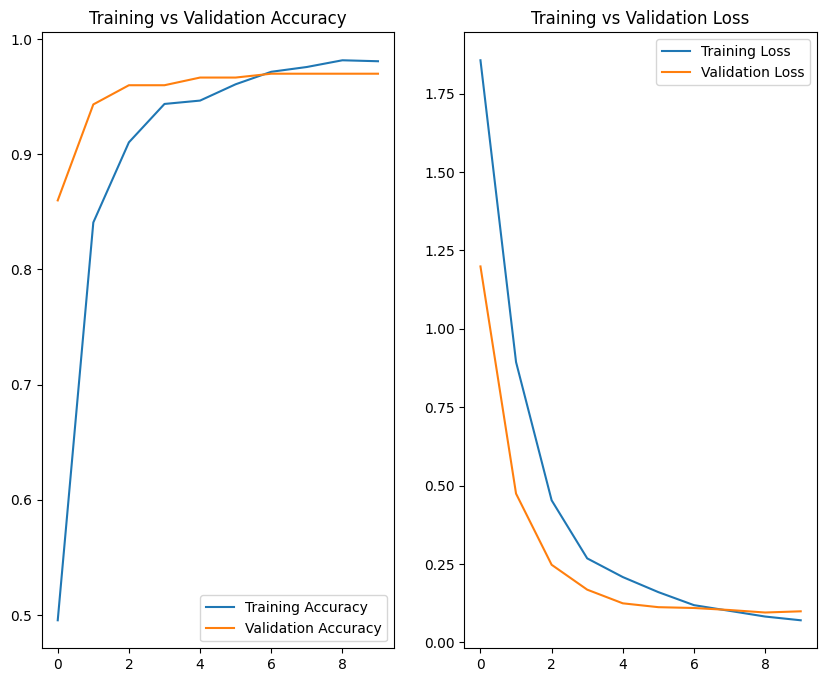

In [ ]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()

## 6.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.

In [ ]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - Accuracy: 0.9796 - loss: 0.0851
Test accuracy is0.9767, Test loss is 0.0788


In [ ]:
# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 28  0  1  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  1  0 29  0  0]
 [ 0  0  1  0  0  0  1  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        30
           2       0.97      1.00      0.98        30
           3       1.00      1.00      1.00        30
           4       1.00      0.93      0.97        30
           5       0.94      0.97      0.95        30
           6       0.91      1.00      0.95        30
           7       0.97      0.97      0.97        30
           8       1.00      0.93      0.97        30
           9       1.00      1.00      1.00        30

    accuracy                    

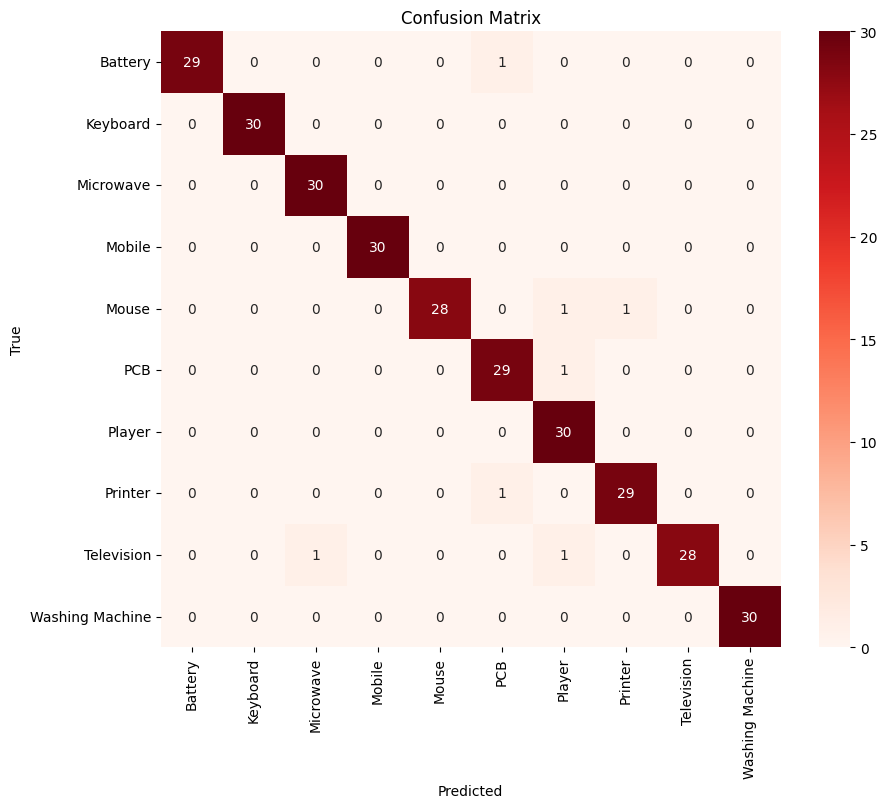

In [ ]:
cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Reds')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()